In [1]:
import os
import sys
import numpy as np
import time

In [2]:
nb_dir = '/home/dhiraj/Documents/anuvaad/anuvaad-etl/anuvaad-extractor/document-processor/word-detector/craft/src'
sys.path.append(nb_dir)
sys.path.append(os.path.split(nb_dir)[0])

import config
import src.utilities.app_context as app_context
app_context.init()

#path to craft model, weight can be pulled form the production bracnh of repo
config.CRAFT_MODEL_PATH= nb_dir + '/utilities/craft_pytorch/model/craft_mlt_25k.pth'
config.CRAFT_REFINE_MODEL_PATH = nb_dir + '/utilities/craft_pytorch/model/craft_refiner_CTW1500.pth'

In [3]:
from src.services.main import TextDetection

Loading weights of refiner from checkpoint (./model/craft_refiner_CTW1500.pth)


In [4]:
base_dir = '/home/dhiraj/Documents/Anuwad/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input'

#filename    = 'hamlet_1.pdf'
#filename     = '35977.pdf'
filename      = 'yolo_1.pdf'
file_format = 'PDF'
language    =  'en'

In [5]:
app_context.application_context = {
  "inputs": [
    {
      "file": {
        "identifier": "string",
        "name": filename,
        "format": file_format
      },
      "config": {
        "OCR": {
          "option": "HIGH_ACCURACY",
          "language": language
        }
      }
    }
  ]
}

In [6]:
resp = TextDetection(app_context,base_dir)

[2020-11-24 17:33:21,690] {loghandler.py:49} MainThread DEBUG in loghandler: Block merger starting processing {'inputs': [{'file': {'identifier': 'string', 'name': 'yolo_1.pdf', 'format': 'PDF'}, 'config': {'OCR': {'option': 'HIGH_ACCURACY', 'language': 'en'}}}]}
[2020-11-24 17:33:21,697] {loghandler.py:21} MainThread INFO in loghandler: created processing directories successfully /home/dhiraj/Documents/Anuwad/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/yolo_1_0c331bf6-2e4d-11eb-8183-eb0c018101c7
[2020-11-24 17:33:21,698] {loghandler.py:21} MainThread INFO in loghandler: filepath /home/dhiraj/Documents/Anuwad/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/yolo_1.pdf, working_dir /home/dhiraj/Documents/Anuwad/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/yolo_1_0c331bf6-2e4d-11eb-8183-eb0c018101c7
[2020-11-24 17:33:22,019] {loghandler.py:21} MainThread INFO in loghandler: Extr

In [9]:
file_index = 0
page_index = 0
to_check  = 'words'

page_1 = resp['rsp']['outputs'][file_index]['pages'][page_index][to_check]
print(len(page_1))

688


In [11]:
file_index = 0
page_index =0
to_check  = 'words'

page_2 = resp['rsp']['outputs'][file_index]['pages'][page_index][to_check]
print(len(page_2))

688


# Panda based query


In [12]:
import numpy as np
import pandas as pd
from shapely.geometry import Polygon


def get_mid_point(region):
    x = (region['vertices'][0]['x']  + region['vertices'][1]['x']) *0.5
    y = (region['vertices'][0]['y'] + region['vertices'][3]['y']) * 0.5
    return [x, y]

def check_if_inside(region, point):
    x, y = point
    if (x >= region[0]['x']) and (x <= region[1]['x']) and (y >= region[0]['y']) and (y <= region[3]['y']):
        return True
    else:
        return False

def get_polygon(vertices):
    points = []
    for point in vertices:
        points.append((point['x'], point['y']))
    poly = Polygon(points)
    return poly

def compare_regions(gt_regions, predicted_regions):
    gt_exists   =  len(gt_regions) > 0
    pred_exists =  len(predicted_regions)>0
    page_iou    = []
    page_ious   = []

    if gt_exists :
        if pred_exists:
            df_predicted =  pd.DataFrame(predicted_regions)
            df_predicted['mid_point'] = df_predicted['boundingBox'].apply(lambda x: get_mid_point(x))

            for gt_region in gt_regions :
                region_vertices = gt_region['boundingBox']['vertices']
                region_filter   = df_predicted['mid_point'].apply(lambda x: check_if_inside(region_vertices, x))
                region_index = np.where(region_filter)[0]

                gt_poly = get_polygon(region_vertices)
                if len(region_index) > 0:
                    ious = []
                    for index in region_index:
                        predicted_region = predicted_regions[index]['boundingBox']['vertices']
                        predicted_poly = get_polygon(predicted_region)
                        region_iou = gt_poly.intersection(predicted_poly).area / gt_poly.union(predicted_poly).area
                        ious.append(region_iou)

                    iou = max(ious)
                    page_iou.append(iou)
                    page_ious.append(ious)
                else:
                    page_iou.append(0)
                    page_ious.append([0]) 
        else :
            page_iou = [0] * len(gt_regions)
            page_ious = [[0]] * len(gt_regions)
        
        return page_iou ,page_ious

    else :
        return [] , []





[2020-11-24 17:35:24,912] {geos.py:73} MainThread DEBUG in geos: Found GEOS DLL: <CDLL '/home/dhiraj/py_envs/Anuvaad/lib/python3.6/site-packages/shapely/.libs/libgeos_c-a68605fd.so.1.13.1', handle e41ec40 at 0x7ff50c212eb8>, using it.
[2020-11-24 17:35:25,008] {geos.py:38} MainThread DEBUG in geos: Trying `CDLL(libc.so.6)`
[2020-11-24 17:35:25,010] {geos.py:55} MainThread DEBUG in geos: Library path: 'libc.so.6'
[2020-11-24 17:35:25,013] {geos.py:56} MainThread DEBUG in geos: DLL: <CDLL 'libc.so.6', handle 7ff59d68a000 at 0x7ff50c212e80>


In [17]:
%%timeit
iou ,ious = compare_regions(page_1,page_2)



526 ms ± 22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [256]:
iou ,ious = compare_regions(page_1,page_2)

In [248]:
iou[:5]

[1.0, 1.0, 1.0, 1.0, 1.0]

In [18]:
#time
df_predicted =  pd.DataFrame(page_2)


In [21]:
%%timeit
df_predicted['mid_point'] = df_predicted['boundingBox'].apply(lambda x: get_mid_point(x))

854 µs ± 13.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [22]:
region_gt = page_1[3]

In [24]:
region_vertices = region_gt['boundingBox']['vertices']

In [27]:
%%timeit
region_filter = df_predicted['mid_point'].apply( lambda x : check_if_inside(region_vertices,x) )



478 µs ± 16.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
region_index = np.where(region_filter)[0]

In [195]:
%%timeit
gt_poly = get_polygon(region_gt['boundingBox']['vertices'])

8.14 µs ± 139 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [ ]:
%%timeit
ious = []
if len(region_index) > 0 :
    for index in region_index:
        predicted_region = page_2[index]['boundingBox']['vertices']
        predicted_poly  = get_polygon(predicted_region)
        
        iou = gt_poly.intersection(predicted_poly).area / gt_poly.union(predicted_poly).area
        ious.append(iou)
        print(iou)

# Shapely based query

In [28]:
from shapely.ops import cascaded_union
from rtree import index

    
def index_tree(poly_index,poly,idx):
    idx.insert(poly_index, poly.bounds)
    
    
    
def get_polygon(region):
    points = []
    vertices  = region['vertices']
    for point in vertices:
        points.append((point['x'], point['y']))
    poly = Polygon(points)
    return poly



def compare_regions(gt_regions, predicted_regions):
    gt_exists   =  len(gt_regions) > 0
    pred_exists =  len(predicted_regions)>0
    idx = index.Index()
    page_iou    = []
    page_ious   = []

    if gt_exists :
        
        if pred_exists:
            perd_polys=[]
            
            for region_idx, region in enumerate(predicted_regions) :
                poly = get_polygon(region['boundingBox'])
                perd_polys.append(poly)
                idx.insert(region_idx, poly.bounds)
            
            for gt_region in gt_regions :
                gt_poly = get_polygon(gt_region['boundingBox'])
                region_index = list(idx.intersection(gt_poly.bounds))
                
                if len(region_index) > 0 :
                    ious = []
                    
                    for intr_index in region_index:
                        predicted_poly = perd_polys[intr_index]
                        region_iou = gt_poly.intersection(predicted_poly).area / gt_poly.union(predicted_poly).area
                        ious.append(region_iou)
                    iou = max(ious)
                    page_iou.append(iou)
                    page_ious.append(ious)
                    
        else :
            page_iou = [0] * len(gt_regions)
            page_ious = [[0]] * len(gt_regions)
        
        return page_iou ,page_ious

    else :
        return [] , []






In [31]:
%%timeit 
iou ,ious = compare_regions(page_1,page_2)

264 ms ± 9.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [322]:
iou ,ious = compare_regions(page_1,page_2)
iou[:5]

[0.0, 0.15547377124410836, 0.10113960113960115, 0.0, 0.0]

In [323]:
df_predicted =  pd.DataFrame(page_2)

In [325]:
%%timeit
df_predicted['polygon'] = df_predicted['boundingBox'].apply(get_polygon)

799 µs ± 22.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [33]:
%%timeit
polygons=[]
for region in page_2 :
    polygons.append(get_polygon(region['boundingBox']))

6.41 ms ± 613 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [328]:
df_predicted.head()

,boundingBox,identifier,class,font,polygon
0,"{'vertices': [{'x': 2055, 'y': 317}, {'x': 207...",698bba8656d14e11bb699b604786d22e,TEXT,"{'family': 'Arial Unicode MS', 'size': 33, 'st...","POLYGON ((2055 317, 2077 317, 2077 350, 2055 3..."
1,"{'vertices': [{'x': 1139, 'y': 526}, {'x': 208...",c0bc09ab1f734ac0aff329268b896687,TEXT,"{'family': 'Arial Unicode MS', 'size': 54, 'st...","POLYGON ((1139 526, 2088 519, 2088 573, 1140 5..."
2,"{'vertices': [{'x': 361, 'y': 520}, {'x': 1063...",3df5346527b940edaf69abcbac5c8117,TEXT,"{'family': 'Arial Unicode MS', 'size': 50, 'st...","POLYGON ((361 520, 1063 520, 1063 570, 361 570..."
3,"{'vertices': [{'x': 361, 'y': 646}, {'x': 2115...",669c276ed03b4997a1c3f056cd05d214,TEXT,"{'family': 'Arial Unicode MS', 'size': 61, 'st...","POLYGON ((361 646, 2115 646, 2115 707, 361 707..."
4,"{'vertices': [{'x': 361, 'y': 772}, {'x': 2110...",95257535dc3c47c8bdc769822f30c5ba,TEXT,"{'family': 'Arial Unicode MS', 'size': 61, 'st...","POLYGON ((361 772, 2110 772, 2110 833, 361 833..."


In [38]:
idx = index.Index()

In [232]:
%%timeit
df_predicted.apply(lambda x: index_tree(x.name,x.polygon,idx) ,axis=1)

26.8 ms ± 1.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [39]:
#%%timeit
for poly_index ,poly in enumerate(polygons):
    idx.insert(poly_index, poly.bounds)

In [236]:
# def generator_function(somedata):
#     for i, obj in enumerate(somedata):
#         print(ob)
#         xmin = obj['boundingBox']['vertices'][0]['x']
#         xmax= obj['boundingBox']['vertices'][1]['x']
#         ymin = obj['boundingBox']['vertices'][0]['y']
#         ymin = obj['boundingBox']['vertices'][3]['y']
#         yield (i, (xmin, ymin, xmax, ymax), obj)


In [239]:
# def generator_function(somedata):
#     for i, obj in enumerate(somedata):
#         yield (i, (obj.xmin, obj.ymin, obj.xmax, obj.ymax), obj)

In [241]:
# r = index.Index(generator_function(polygons))

In [379]:
idx

rtree.index.Index(bounds=[359.0, 317.0, 2115.0, 2956.0], size=188)

In [40]:
region_gt = page_1[0]['boundingBox']

gt_poly = get_polygon(region_gt)

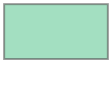

In [41]:
gt_poly

In [43]:
%%timeit 
idx.intersection(gt_poly.bounds)

75.9 µs ± 1.92 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [180]:
idx

rtree.index.Index(bounds=[360.0, 515.0, 2117.0, 3020.0], size=102)

In [181]:
list(idx.intersection(gt_poly.bounds))

[]